In [1]:
import sys
from pathlib import Path
import pandas as pd

sys.path.insert(0, str(Path.cwd().parent))

import numpy as np
from cogwheel import data, gw_utils, gw_plotting, utils
from dot_pe import inference


# Generate synthetic data for inference

In [2]:
# create data
event_data_kwargs = {
    "detector_names": "HLV",
    "duration": 120.0,
    "asd_funcs": ["asd_H_O3", "asd_L_O3", "asd_V_O3"],
    "tgps": 0.0,
    "fmax": 1600.0,
}

eventname = "test_event"

event_data = data.EventData.gaussian_noise(
    eventname=eventname, **event_data_kwargs, seed=20250311
)

mchirp = 75
q = 1 / 2

m1, m2 = gw_utils.mchirpeta_to_m1m2(mchirp, gw_utils.q_to_eta(q))
injection_par_dic = dict(
    m1=m1,
    m2=m2,
    ra=0.5,
    dec=0.5,
    iota=np.pi * 1 / 3,
    psi=1.0,
    phi_ref=12.0,
    s1z=0.6,
    s2z=0.6,
    s1x_n=0.1,
    s1y_n=0.2,
    s2x_n=0.3,
    s2y_n=-0.2,
    l1=0.0,
    l2=0.0,
    tgps=0.0,
    f_ref=50.0,
    d_luminosity=5e3,
    t_geocenter=0.0,
)

event_data.inject_signal(injection_par_dic, "IMRPhenomXODE")

print(event_data.injection["d_h"] - event_data.injection["h_h"] / 2)
print(sum(event_data.injection["d_h"] - event_data.injection["h_h"] / 2))

[13.05668831 32.44716761  1.04042227]
46.544278189095614


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Alternatively, load data form file

`event_data = data.EventData.from_npz(filename="../test_event.npz")`

Set bank folder, in the relevant mass range.

See how to create mass ranges in create_sample_bank.ipynb


In [3]:
bank_folder = "test_bank"
bank_folder = Path(bank_folder)
event_dir = event_data.eventname
bank = pd.read_feather(bank_folder / "intrinsic_sample_bank.feather")
bank_size = len(bank)
mchirp = gw_utils.m1m2_to_mchirp(bank["m1"], bank["m2"])

intrinsic_samples_idx = np.where((mchirp > 60) & (mchirp < 90))[0]
np.save(file="test_event/inds_in_mass_range.npy", arr=intrinsic_samples_idx)

In [ ]:
intrinsic_samples_idx

In [4]:
rundir = inference.run(
    event_dir=event_dir,
    event=event_data,
    bank_folder=bank_folder,
    n_int=bank_size,
    n_ext=512,
    n_phi=64,
    n_phi_incoherent=32,
    n_t=64,
    i_int_start=0,
    blocksize=min(bank_size, 4096),
    single_detector_blocksize=min(bank_size, 4096),
    seed=42,
    size_limit=10**6,
    draw_subset=False,
    n_draws=None,
    preselected_indices="test_event/inds_in_mass_range.npy",
)

Setting paths & loading configurations...
Creating COGWHEEL objects...
Searching incoherent solution for test_event
Set intrinsic parameters, lnL = 53.38219019331538
Set time, lnL(L) = 37.90466501126294
Set sky location, lnL = 52.57982514168386
Set phase and distance, lnL = 52.57982514168386
Set mchirp_range = (np.float64(17.827463734192232), np.float64(198.8935035423655))


Processing intrinsic batches: 100%|██████████| 1/1 [00:03<00:00,  3.02s/it]


1607 intrinsic samples selected.
Generating extrinsic samples...


2025-09-07 13:36:58 - Getting 16 MarginalizationInfo objects.
Marginalization objects: 100%|██████████| 16/16 [00:04<00:00,  3.42obj/s, batches=1/51, accepted=16/16]
2025-09-07 13:37:04 - MarginalizationInfo object created!
2025-09-07 13:37:04 - Saving MarginalizationInfo object to test_event/run_5.


Creating 1 x 1 likelihood blocks...


Coherent likelihood blocks: 100%|██████████| 1/1 [00:02<00:00,  2.66s/it]


Saving samples to file...
Standardizing samples...
Standardizing samples done in 101 seconds.
Saving samples to file...
Samples saved to:
 test_event/run_5/samples.feather


In [7]:
rundirs = sorted(
    Path(eventname).glob("run_*"),
    key=lambda x: int(x.name.split("_")[-1]),
)

rundir = rundirs[-1]
summary_results = utils.read_json(rundirs[-1] / "summary_results.json")

for k, v in summary_results.items():
    print(k, v)

n_effective 1645.7204448212901
n_effective_i 28.170178450544697
n_effective_e 60.86233846008838
bestfit_lnlike_max 53.343073411656974
lnl_marginalized_max 50.452583239000475
n_i_inds_used 1607
ln_evidence 24.370789856674648
ln_evidence_discarded 13.935995397574573
n_distance_marginalizations 1305057
injection {'bestfit_lnlike': 46.86562922368122, 'lnl_marginalized': 43.40632219234138}


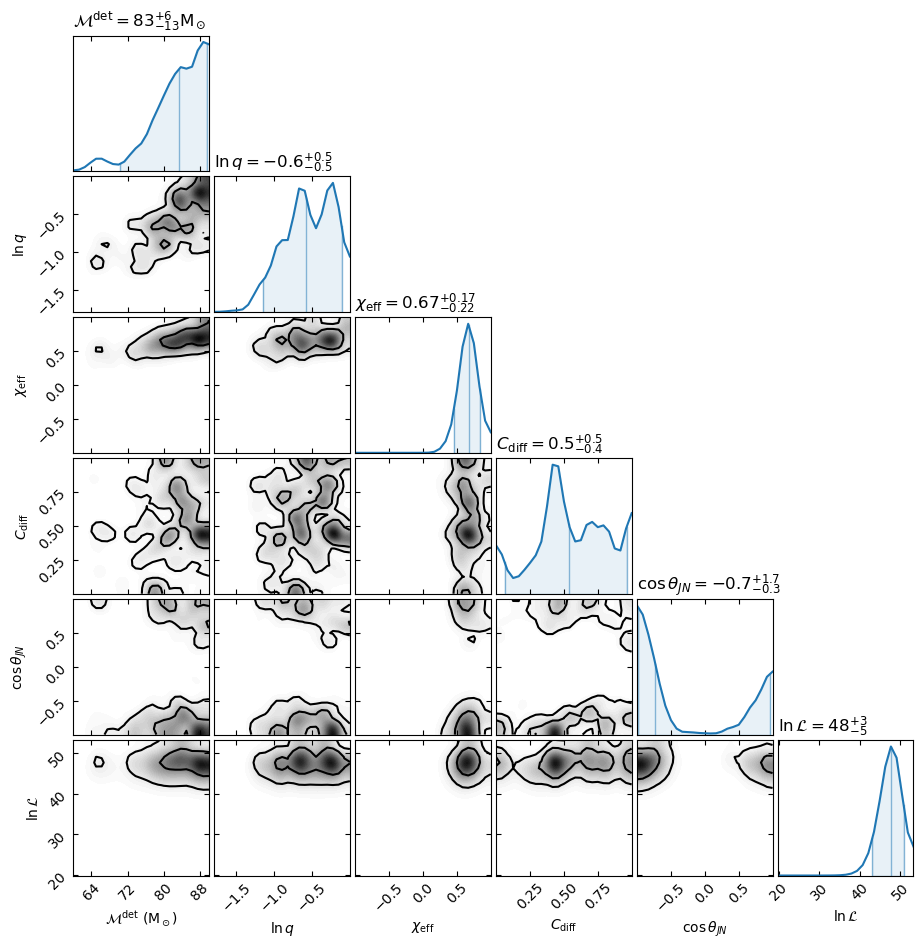

In [8]:
samples = pd.read_feather(rundirs[-1] / "samples.feather")
params = ["mchirp", "lnq", "chieff", "cumchidiff", "costheta_jn", "lnl"]
gw_plotting.CornerPlot(samples, params=params, smooth=1).plot()

In [ ]:
samples["mchirp"].describe()

In [ ]:
# Optional: Load existing results and run post-processing only
# can be used for debugging

event_data = data.EventData.from_npz(filename=rundir / (eventname + ".npz"))
bank_folder = Path("test_bank")
posterior = utils.read_json(rundir / "Posterior.json")
pr = posterior.prior
# Load the intrinsic indices that were used
intrinsic_data = np.load(rundir / "intrinsic_samples.npz")
inds = intrinsic_data["inds"]
bank_size = len(pd.read_feather(bank_folder / "intrinsic_sample_bank.feather"))

# Run post-processing only
samples = inference.postprocess(
    event_data=event_data,
    rundir=rundir,
    bank_folder=bank_folder,
    n_int=bank_size,
    inds=inds,
    n_ext=512,
    n_phi=32,
    pr=pr,
    draw_subset=False,
    n_draws=None,
)

# Save the new samples
samples.to_feather(rundir / "samples_postprocess_only.feather")
print(
    f"Post-processing completed. Samples saved to {rundir / 'samples_postprocess_only.feather'}"
)

# Compare with original results
original_samples = pd.read_feather(rundir / "samples.feather")
print(f"Original samples shape: {original_samples.shape}")
print(f"New samples shape: {samples.shape}")